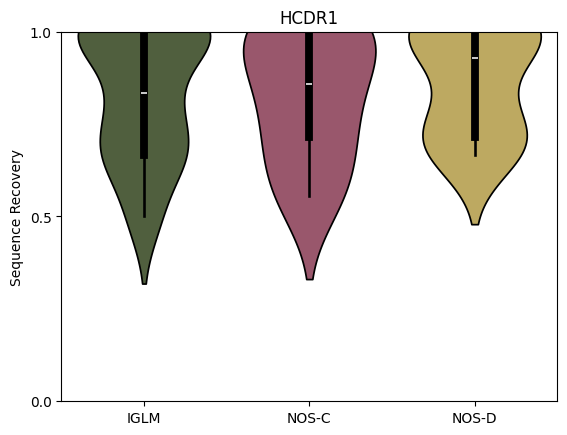

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_col(fn, sample_tag, col_name):
    df = pd.read_csv(fn)
    return df[df['sample_tag'] == sample_tag][col_name].values

sample = 'chothia_hcdr1'

iglm_fn = 'data/iglm_fixed_samples_labeled.csv'
iglm_data = get_col(iglm_fn, sample, 'seq_recovery')


nosc_fn = 'data/gaussian_fixed_length=True_samples_labeled.csv'
nosc_data = get_col(nosc_fn, sample, 'seq_recovery')

nosd_fn = 'data/mlm_fixed_length=True_samples_labeled.csv'
nosd_data = get_col(nosd_fn, sample, 'seq_recovery')

data = {
    'IGLM': iglm_data,
    'NOS-C': nosc_data,
    'NOS-D': nosd_data
}

group_names = []
values = []
for group, samples in data.items():
    group_names.extend([group] * len(samples))
    values.extend(samples)

df = pd.DataFrame({"HCDR1": group_names, "SeqRecovery": values})

sns.violinplot(x='HCDR1', y='SeqRecovery', data=df, inner='box', palette=['#506538', '#A44C68', '#CCB252'], hue='HCDR1', linecolor='black')

max_seq_recov = max([np.max(d) for d in data.values()])
plt.ylim(top=max_seq_recov)
plt.title('HCDR1')
plt.xlabel('')
plt.ylabel('Sequence Recovery')
plt.yticks(np.linspace(0, 1, 3))
plt.show()